In [233]:
import pandas as pd
import os

# Define the directory paths
People = "C:\\Users\\thema\\Desktop\\Content_2\\USD\\Intro to\\archive\\human detection dataset\\1"
Not_People = "C:\\Users\\thema\\Desktop\\Content_2\\USD\\Intro to\\archive\\human detection dataset\\0"

# Function to create DataFrame from directory path
def directory_to_dataframe(directory):
    files = os.listdir(directory)
    df = pd.DataFrame(files, columns=['filename'])
    df['filepath'] = directory + '\\' + df['filename']
    return df

# Convert directories to DataFrames
df_people = directory_to_dataframe(People)
df_not_people = directory_to_dataframe(Not_People)

# Print shapes of the DataFrames
print("Shape of People DataFrame:", df_people.shape)
print("Shape of Not_People DataFrame:", df_not_people.shape)



Shape of People DataFrame: (559, 2)
Shape of Not_People DataFrame: (362, 2)


In [234]:
# Combine both DataFrames
df_combined = pd.concat([df_people, df_not_people], ignore_index=True)

# Print the shape of the combined DataFrame
print("Shape of Combined DataFrame:", df_combined.shape)

Shape of Combined DataFrame: (921, 2)


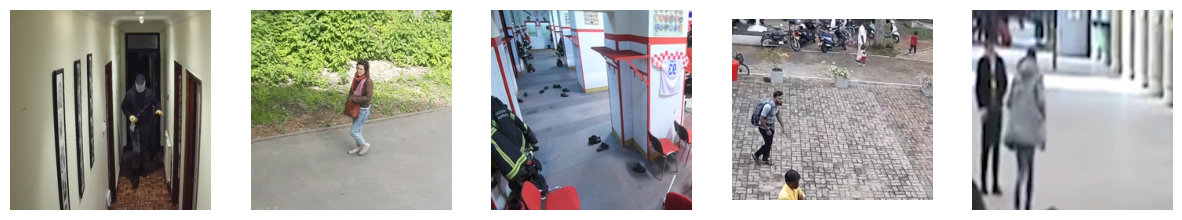

In [235]:
# Function to display random images from DataFrame
def display_random_images(dataframe, num_images):
    random_indices = random.sample(range(len(dataframe)), num_images)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i, idx in enumerate(random_indices):
        img = Image.open(dataframe.loc[idx, 'filepath'])
        axes[i].imshow(img)
        axes[i].axis('off')
    plt.show()

# Display 5 random images from the combined DataFrame
display_random_images(df_combined, 5)

In [236]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

# Function to load and preprocess images
def load_and_preprocess_images(directory):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith(".png"):  # Check if file is PNG
            img = load_img(os.path.join(directory, filename), target_size=(224, 224))
            img = img_to_array(img)
            img = np.expand_dims(img, axis=0)
            img = tf.keras.applications.vgg16.preprocess_input(img)
            images.append(img)
    return np.vstack(images)

# Load and preprocess images from People and Not_People directories
people_images = load_and_preprocess_images(People)
not_people_images = load_and_preprocess_images(Not_People)

# Create labels for the images (1 for people, 0 for not people)
people_labels = np.ones(len(people_images))
not_people_labels = np.zeros(len(not_people_images))

# Combine images and labels
X = np.vstack((people_images, not_people_images))
y = np.hstack((people_labels, not_people_labels))

# Split dataset into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Print shapes of datasets
print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_val:", y_val.shape)
print("Shape of y_test:", y_test.shape)



Shape of X_train: (552, 224, 224, 3)
Shape of X_val: (184, 224, 224, 3)
Shape of X_test: (185, 224, 224, 3)
Shape of y_train: (552,)
Shape of y_val: (184,)
Shape of y_test: (185,)


In [237]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Load pre-trained VGG16 model (excluding the top dense layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers on top
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification output

# Create the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define callbacks
checkpoint = ModelCheckpoint("vgg16_model.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='max', restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train,
                    batch_size=16,
                    epochs=10,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, early_stopping])

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)


Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.6976 - loss: 11.1980
Epoch 1: val_accuracy improved from -inf to 0.78804, saving model to vgg16_model.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 24s 660ms/step - accuracy: 0.6993 - loss: 11.1237 - val_accuracy: 0.7880 - val_loss: 3.8260
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.9034 - loss: 1.6209
Epoch 2: val_accuracy improved from 0.78804 to 0.82065, saving model to vgg16_model.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 22s 632ms/step - accuracy: 0.9035 - loss: 1.6195 - val_accuracy: 0.8207 - val_loss: 2.4383
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.9378 - loss: 0.7266
Epoch 3: val_accuracy improved from 0.82065 to 0.89130, saving model to vgg16_model.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 22s 634ms/step - accuracy: 0.9383 - loss: 0.7192 - val_accuracy: 0.8913 - val_loss: 1.2732
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.9884 - loss: 0.1286
Epoch 4: val_accuracy did not imp

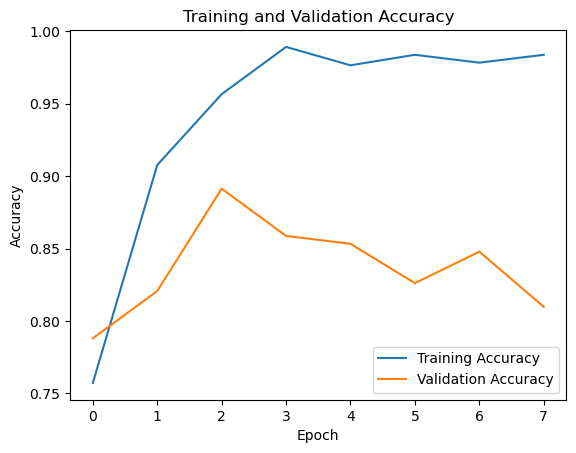

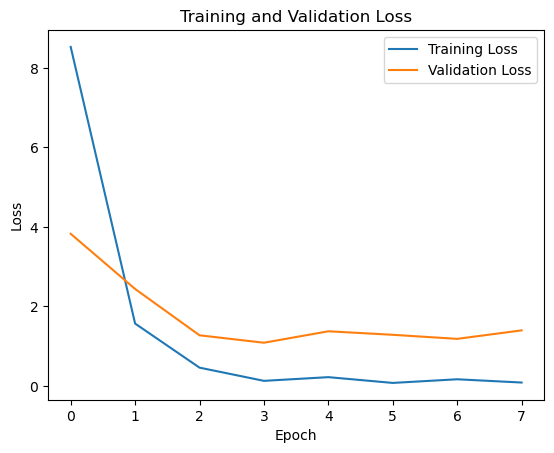

In [239]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [240]:
# Unfreeze some layers of the base model for fine-tuning
for layer in base_model.layers[15:]:
    layer.trainable = True

# Compile the model again after unfreezing layers
model.compile(optimizer=Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define callbacks for model checkpoint and early stopping
checkpoint = ModelCheckpoint("vgg16_fine_tuned_model.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='max', restore_best_weights=True)

# Fine-tune the model
history_fine_tuned = model.fit(X_train, y_train,
                                batch_size=16,
                                epochs=10,
                                validation_data=(X_val, y_val),
                                callbacks=[checkpoint, early_stopping])

# Evaluate the fine-tuned model on the test set
test_loss_fine_tuned, test_acc_fine_tuned = model.evaluate(X_test, y_test)
print('Test loss (fine-tuned):', test_loss_fine_tuned)
print('Test accuracy (fine-tuned):', test_acc_fine_tuned)


Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - accuracy: 0.9521 - loss: 0.2581
Epoch 1: val_accuracy improved from -inf to 0.84783, saving model to vgg16_fine_tuned_model.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 26s 727ms/step - accuracy: 0.9523 - loss: 0.2582 - val_accuracy: 0.8478 - val_loss: 0.9701
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - accuracy: 0.9714 - loss: 0.1661
Epoch 2: val_accuracy did not improve from 0.84783
35/35 ━━━━━━━━━━━━━━━━━━━━ 24s 702ms/step - accuracy: 0.9710 - loss: 0.1699 - val_accuracy: 0.8478 - val_loss: 0.5427
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - accuracy: 0.9792 - loss: 0.0592
Epoch 3: val_accuracy improved from 0.84783 to 0.89674, saving model to vgg16_fine_tuned_model.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.9791 - loss: 0.0593 - val_accuracy: 0.8967 - val_loss: 0.3729
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.9959 - loss: 0.0236
Epoch 4: val_accuracy improved from 0.89674 to 0.91304,

In [241]:
import random

# Concatenate the DataFrames
df_combined = pd.concat([df_people, df_not_people], ignore_index=True)

# Randomly select an image path from the combined DataFrame
random_row = random.choice(range(len(df_combined)))
random_image_path = df_combined.loc[random_row, 'filepath']

# Now you can use this random_image_path for testing


In [242]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf

# Function to preprocess a single image
def preprocess_single_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg16.preprocess_input(img)
    return img

# Preprocess the randomly selected image
preprocessed_image = preprocess_single_image(random_image_path)

# Now, you can use this preprocessed_image for testing with your model
# For example, if your model is named 'model', you can make predictions as follows:
# predictions = model.predict(preprocessed_image)
# Then, you can interpret the predictions to determine if the image contains a person or not


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


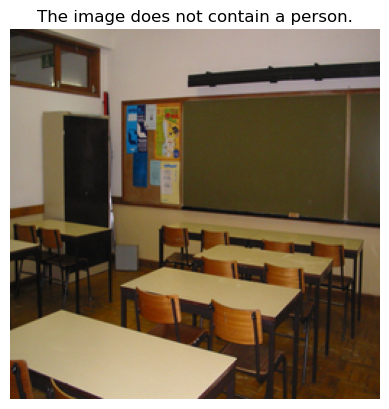

In [261]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf

# Function to preprocess a single image
def preprocess_single_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg16.preprocess_input(img)
    return img

# Function to display image and prediction result
def display_image_with_prediction(image_path, prediction):
    img = load_img(image_path)
    plt.imshow(img)
    plt.axis('off')
    if prediction > 0.5:
        plt.title("The image contains a person.")
    else:
        plt.title("The image does not contain a person.")
    plt.show()

# Select a random image path from the dataset
random_row = random.choice(range(len(df_combined)))
random_image_path = df_combined.loc[random_row, 'filepath']

# Preprocess the randomly selected image
preprocessed_image = preprocess_single_image(random_image_path)

# Make predictions using your trained model
predictions = model.predict(preprocessed_image)

# Display the image and prediction result
display_image_with_prediction(random_image_path, predictions[0])
